## Emulator validation

We need some figure to verify the accuracy of emulator predictions through comparison with the truth. Simeon's paper had a cross-validation plot, but this stacks all $z$ and $k$ bins into one histogram. We know that our emulator performance has some redshfit and k dependence, and so it is important this is shown in whatever validation figure we include.

The leave-one-out test I conducted is similar to having a cross-validation at each $k$ and $z$. Although it might require some discussion, lets try and include this figure.

So the way this works is for each simulation we have in the suite, it uses every other simulation to predict a P1D for every snapshot in that test simulation. We store the ratio of the prediction/truth, and the fractional theoretical uncertainty at each k and z.

We can then plot the mean and variance of the prediction/truth (what I would consider to be the true error) and of the fractional theoretical uncertainty as a function of $k$ and $z$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# our own modules
from lace.emulator import gp_emulator
from lace.emulator import p1d_archive
from lace.cosmo import camb_cosmo
from lace_manager.data import data_Chabanier2019

In [2]:
font = {'size'   : 22}
matplotlib.rc('font', **font)
plt.rc('text', usetex=False)
plt.rc('font', family='FreeSerif')
matplotlib.rcParams['mathtext.fontset'] = 'cm'

In [3]:
skewers_label='Ns500_wM0.05'
p1d_label=None
basedir="/lace/emulator/sim_suites/Australia20/"
kmax_Mpc=3
zmax=4

In [4]:
set_k=p1d_archive.archiveP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=zmax,pick_sim_number=0,
                            drop_temp_rescalings=True,skewers_label=skewers_label)
## Set up k bins for emulator call
k_test=set_k.data[1]["k_Mpc"][1:]
k_test=k_test[k_test<kmax_Mpc]

In [5]:
## Set up cosmology to get BOSS k_max at each z where we have data
cosmo_fid=camb_cosmo.get_cosmology()

In [6]:
chab=data_Chabanier2019.P1D_Chabanier2019()

In [7]:
def leave_one_out_rbf():
    """ This will loop over each simulation in the suite. It will load all other simulations
    as training data, and use the default hyperparameters to make an emulator prediction.
    It then calculates the mean and variance of the prediction/truth ratio, and the mean
    and the variance of the fractional error as a function of k and z"""
    
    ## Data arrays
    fractional_error=np.empty((30,9,len(k_test)))
    theory_error=np.empty((30,9,len(k_test)))


    for simnum in range(0,30):
        truth=p1d_archive.archiveP1D(basedir=basedir,
                                drop_tau_rescalings=True,z_max=zmax,pick_sim_number=simnum,
                                drop_temp_rescalings=True,skewers_label=skewers_label)
        training=p1d_archive.archiveP1D(basedir=basedir,
                                drop_tau_rescalings=True,z_max=zmax,drop_sim_number=simnum,
                                drop_temp_rescalings=True,skewers_label=skewers_label)
                            
        
        emu_test=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=zmax,kmax_Mpc=kmax_Mpc,
                                verbose=False,paramList=None,train=True,asymmetric_kernel=True,
                                emu_type="k_bin",passarchive=training,rbf_only=True,
                                drop_tau_rescalings=True,check_hull=False,
                                drop_temp_rescalings=True)
        #emu_test.load_default()
        
        
        for aa,item in enumerate(truth.data):
            emu_call={}
            for bb,param in enumerate(emu_test.paramList):
                emu_call[param]=item[param]

            pred,err=emu_test.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
            


            fractional_error[simnum,aa,:]=pred/item["p1d_Mpc"][1:(len(k_test)+1)]
            #theory_error[simnum,aa,:]=(pred+np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)]
            theory_error[simnum,aa,:]=(np.sqrt(np.diag(err)))/pred

            #if item["z"]==2:
            #    print(simnum)
            #    print((np.sqrt(np.diag(err)))/pred)
            
    return np.mean(fractional_error,axis=0),np.std(fractional_error,axis=0),np.median(theory_error,axis=0),np.std(theory_error,axis=0)

In [8]:
mean_ratio_rbf,std_ratio_rbf,mean_error_rbf,var_error_rbf=leave_one_out_rbf()

 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 261 points
GPs optimised in 1.03 seconds
Training GP on 261 points
GPs optimised in 0.98 seconds
Training GP on 261 points
GPs optimised in 0.88 seconds
Training GP on 261 points
GPs optimised in 0.97 seconds
Training GP on 261 points
GPs optimised in 0.76 seconds
Training GP on 261 points
GPs optimised in 0.98 seconds
Training GP on 261 points
GPs optimised in 0.84 seconds
Training GP on 261 points
GPs optimised in 0.95 seconds
Training GP on 261 points
GPs optimised in 0.74 seconds
Training GP on 261 points
GPs optimised in 0.56 seconds
Training GP on 261 points
GPs optimised in 0.84 seconds
Training GP on 261 points
GPs optimised in 0.72 seconds
Training GP on 261 points
GPs optimised in 0.75 seconds
Training GP on 261 points
GPs optimised in 0.70 seconds
Training GP on 261 points
GPs optimised in 0.54 seconds
Training GP on 261 points
GPs optimised in 0.58 seconds
Training GP on 261 points
GPs optimised in 0.65 seconds
Training GP on 261 points
GPs optimised in 0.57 

findfont: Font family ['FreeSerif'] not found. Falling back to DejaVu Sans.


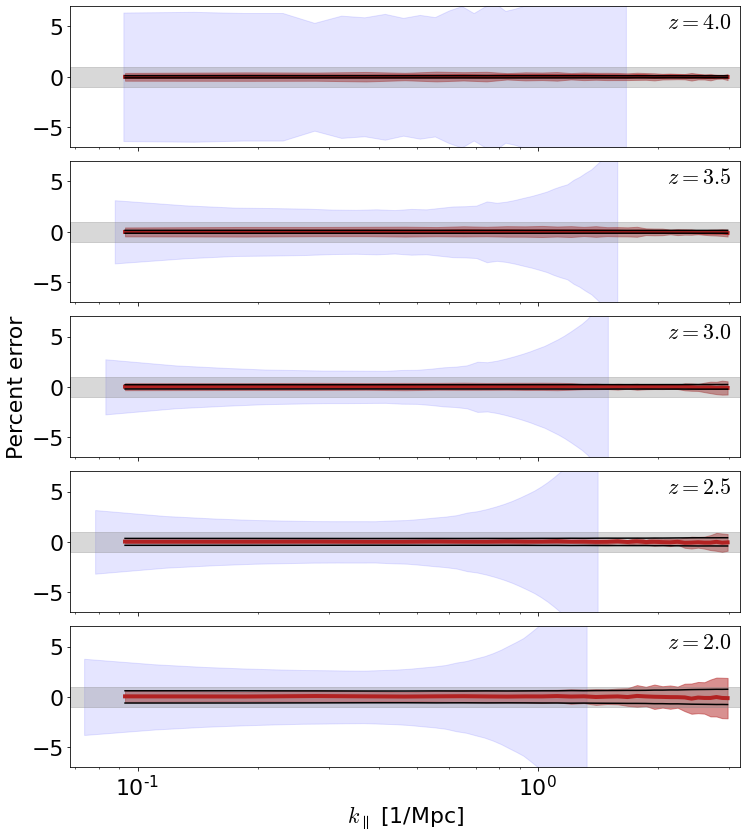

In [9]:
plt.figure(figsize=[12,14])

xmin=0.068
xmax=3.2

dex=0
for aa in range(0,9,2):
    plt.subplot(5,1,int(aa/2)+1)
    col = "firebrick"

    ## Chabanier fractional error for comparison
    chab_index=np.abs(set_k.data[aa]["z"] - chab.z).argmin()
    chab_pk=chab.get_Pk_iz(chab_index)
    chab_cov=chab.get_cov_iz(chab_index)
    chab_err=np.sqrt(np.diag(chab_cov))
    
    data_k=chab.k*camb_cosmo.dkms_dMpc(cosmo_fid,set_k.data[aa]["z"])
    
    plt.fill_between(data_k,100*chab_err/chab_pk,-100*chab_err/chab_pk,alpha=0.1,color="blue")
    plt.plot(k_test,100*(mean_ratio_rbf[aa,:]-1),color=col,label="z=%.2f" % set_k.data[aa]["z"],linewidth=4)
    plt.plot(k_test,100*(mean_error_rbf[aa,:]),color="black")
    plt.plot(k_test,-100*mean_error_rbf[aa,:],color="black")
    plt.fill_between(k_test,100*((mean_ratio_rbf[aa,:]+std_ratio_rbf[aa,:])-1),
            100*((mean_ratio_rbf[aa,:]-std_ratio_rbf[aa,:])-1),alpha=0.5,color=col)
    plt.axhspan(-1,1,color="gray",alpha=0.3)

    #plt.axhline(0,linestyle="dashed",color="gray")
    plt.ylim(-7,7)
    #plt.legend(loc="lower right")
    ax = plt.gca()
    ax.set_xscale("log")
    plt.xlim(xmin,xmax)
    #ax.tick_params(top=True,right=True)
    
    ax.text(2.1,4.8,r"$z=%.1f$" % set_k.data[aa]["z"])

    if aa != 8:
        ax.axes.xaxis.set_ticklabels([])
        #ax.axes.yaxis.set_ticklabels([])
    if aa==4:
        plt.ylabel("Percent error")
plt.subplots_adjust(hspace=0.1)
plt.xlabel(r"$k_\parallel$ [1/Mpc]")
plt.savefig("one_out.pdf", bbox_inches = 'tight',pad_inches = 0)